# Introduction: Google Earth Engine and Satellite Imagery

This notebook is about the use of **Google Earth Engine (GEE)** with satellite imagery. Google Earth Engine is a powerful platform because it gives you quick access to a vast collection of satellite image catalogs, which can be employed for many kinds of **geospatial analysis**, including applications in **water management**.

In this tutorial, we will learn how to interface with these catalogs and specifically work with the **harmonized Sentinel-2 dataset** — one of the most widely used remote sensing products for environmental monitoring.

>**Note**: Of course, you are not required to use this material for the hackathon. The purpose of this tutorial is simply to help you become familiar with tools and concepts you might not have seen before, or only know at a basic level. Some parts may feel a bit challenging, since geospatial analysis and remote sensing involve advanced ideas that normally require specialized expertise. Still, we provide this notebook so you can explore it if you wish — whether to inspire new approaches, or simply to broaden your understanding.



## A Quick Primer on Remote Sensing

**Remote sensing** means observing the Earth’s surface from a distance, usually through satellites or aircraft, rather than by direct contact. Satellite sensors capture the **reflected or emitted energy** from the Earth in different portions of the electromagnetic spectrum. These measurements are stored as **bands**.

* Each **band** corresponds to a specific wavelength (for example, visible light, near-infrared, or shortwave infrared).
* By combining or comparing different bands, we can extract useful information about vegetation, soils, or water.

For instance, **vegetation** reflects strongly in the near-infrared band, which allows us to assess plant health. Similarly, **water** has distinct spectral properties that vary with its quality.


## Using Remote Sensing as a Proxy for Water Quality

Water quality cannot be measured directly by satellites, but we can build **proxies** — indirect indicators that relate spectral signals to water quality parameters, for instance:

* **Turbidity**: Cloudy water scatters light differently, which changes how water reflects in visible and near-infrared bands.
* **Chlorophyll-a**: This pigment is produced by algae. Higher concentrations often indicate **eutrophication** (excessive nutrient levels leading to algal blooms). Algae affect how water reflects light, especially in green and red-edge bands.

By mixing information from different bands, we can create **indices** that serve as proxies for such parameters.

While proxies are useful, they are strongest when supported by **in-situ measurements** (e.g., water samples collected in rivers or lakes). These ground observations can be used to:

* Calibrate the remote sensing proxies,
* Validate whether satellite-derived estimates are accurate, and
* Train data-driven models (such as machine learning approaches) to improve predictions of water quality.

> **Note**: In this tutorial we focus on water quality as an example, mainly to show the functionality of Google Earth Engine with satellite data. However, remote sensing can also be applied to many other water management problems, such as measuring flood inundation, tracking river morphology changes, or assessing land use and land cover changes, which in turn influence both water quality and water quantity. The same tools you practice here can be adapted for a wide range of challenges beyond water quality.

## Installations

In [1]:
!pip install -q earthengine-api
!pip install -q geemap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 36.7 MB/s eta 0:00:00


In [2]:
import ee
ee.Authenticate(auth_mode='notebook')
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/cloud-platform%20https%3A//www.googleapis.com/auth/drive%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=ac4OPe-rydVN6RU24I08yxcJEUpTkQhknDuPeH4cctk&tc=AsLJDQyrSmcGiSbP6S1qyXFZ0puOYTQimChp2zxX5fE&cc=5P41zWJ9_vrGRDlXpLCMRL4zhb9LbQSIbTBkH5jRSjk

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AVMBsJhQ-mku-PQti50oLOmntl05w74fqInMgdYq1JtQuJxsUVhR0xa2gJc

Successfully saved authorization token.


*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_7TDKVSyKvBdmMqW?ref=4i2o6


## First steps: retrieve Sentinel-2 satellite imagery for Waternet Headquarter

[**Sentinel-2**](https://en.wikipedia.org/wiki/Sentinel-2) is a European satellite mission that takes detailed pictures of the Earth in many different wavelengths of light (multi-spectral). It is mainly used to monitor land and water, for example vegetation, soil, rivers, lakes, and coastal zones. The Earth is split into **tiles**, each covering a fixed area; when put together, these tiles give us global coverage. Because the satellites orbit the Earth, they pass over the same place several times each month (this is called the “revisit” or “revolution time”), so multiple images are available for each location.

To begin exploring, we will download the Sentinel-2 tile that covers the area where the Waternet headquarters is located. We will focus on a single month. Since several images are usually available for that period, we will select the one with the **lowest cloud cover**, as clouds can block the satellite view and reduce image quality.

We will plot the RGB bands, which correspond to visible light. In Sentinel-2: Band 2 represents blue, Band 3 represents green, Band 4 represents red. By combining these three bands, we can create a **natural-color image** similar to what the human eye would see. These bands are available at a **spatial resolution of 10 meters**, meaning each pixel represents an area of 10 × 10 m on the ground.

In [3]:
import geemap

In [15]:
# Basic rectangular polygon for the area of WaternetHQ
west = 4.912
south = 52.339
east = 4.918
north = 52.343

# Define a rectangular polygon using bounding coordinates (west, south, east, north)
# ee.Geometry.Rectangle creates a geometry object in Earth Engine that can be used
# for queries, filtering, or visualization.
waternetHQ = ee.Geometry.Rectangle([west, south, east, north])

# Get the centroid (geometric center point) of the polygon.
baricenter = waternetHQ.centroid()
print(baricenter.getInfo())  # Print the coordinates of the baricenter


{'type': 'Point', 'coordinates': [4.915000000019417, 52.34100000781078]}


In [5]:
# Load the Sentinel-2 Surface Reflectance (harmonized) image collection.
# Then filter it so that:
# 1. Only images covering the Waternet HQ area are kept (filterBounds).
# 2. Only images acquired in May 2023 are included (filterDate).
s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
    .filterBounds(waternetHQ) \
    .filterDate('2023-05-01', '2023-05-31')

# Count how many images there are
count = s2.size().getInfo()

print(f"Number of Sentinel-2 images in May 2025 over waternetHQ: {count}")

Number of Sentinel-2 images in May 2025 over waternetHQ: 12


#### Select the least cloudy satellite image

In [17]:
import datetime

# Filter the collection to keep only images with less than 10% cloud cover
s2_clear = s2.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))

# Sort the retrieved images by cloudiness (ascending) and select the first one,
# i.e. the least-cloudy image in the collection
best = s2_clear.sort('CLOUDY_PIXEL_PERCENTAGE').first()

# Retrieve some metadata: image ID, cloud percentage, and acquisition time
image_id = best.id().getInfo()
cloud_pct = best.get('CLOUDY_PIXEL_PERCENTAGE').getInfo()

# Convert the acquisition time (in milliseconds since epoch) into a readable datetime
image_time_start = best.get('system:time_start').getInfo()
image_date = datetime.datetime.fromtimestamp(image_time_start / 1000)

# Print out the details of the selected image
print(f"Best image: {image_id}")
print(f"Cloudy pixel percentage: {cloud_pct:.2f}%")
print(f"Acquisition DateTime: {image_date.strftime('%Y-%m-%d %H:%M')}")

Best image: 20230527T103629_20230527T103641_T31UFU
Cloudy pixel percentage: 5.48%
Acquisition DateTime: 2023-05-27 10:46


#### Plot RGB data from satellite

In [19]:
# Create an interactive map and center it on the Waternet HQ polygon
Map = geemap.Map()
Map.center_object(waternetHQ, zoom=16)

# Define visualization parameters for a true-color RGB image:
# - Use bands B4 (red), B3 (green), B2 (blue)
# - Show pixel brightness on a scale from 0 (darkest) to 3000 (brightest).
#   This makes the image look more natural to the human eye.
rgb_vis = {
    'bands': ['B4', 'B3', 'B2'],  # Sentinel-2 bands for Red (B4), Green (B3), Blue (B2)
    'min': 0,                    # Minimum pixel value for display
    'max': 3000                  # Maximum pixel value for display (adjust as needed)
}

# Add the least-cloudy Sentinel-2 image ('best') as an RGB layer
Map.addLayer(best, rgb_vis, 'RGB Composite')

# Create an outline for the Waternet HQ polygon:
# - black border, thick stroke, no fill (transparent inside)
outline = ee.FeatureCollection([ee.Feature(waternetHQ)]).style(
    color='black',        # stroke
    width=10,            # stroke width
    fillColor='#00000000'  # fully transparent fill
)
Map.addLayer(outline, {}, 'WaternetHQ')

Map

Map(center=[52.34100000781078, 4.915000000019417], controls=(WidgetControl(options=['position', 'transparent_b…

## Estimating water quality with Sentinel-2 imagery

Sentinel-2 images can be used to estimate **chlorophyll-a**, which is an important indicator of algae growth and overall water quality. To do this, we look at how water reflects light in different parts of the spectrum. In particular, chlorophyll absorbs most of the **red light** but reflects more in the [**red-edge region**](https://en.wikipedia.org/wiki/Red_edge) (just beyond red).

Raw satellite data, however, can be affected by the atmosphere (for example haze or scattering). To reduce this problem, we use the **surface reflectance (SR)** product in Google Earth Engine (`COPERNICUS/S2_SR_HARMONIZED`), which has already been corrected for atmospheric effects. This gives us a clearer view of the water surface.

To create a proxy for chlorophyll-a, we use a simple ratio:

$$
\text{Index} = \frac{B5 - B4}{B5 + B4}
$$

where

* **B4** is the red band (665 nm),
* **B5** is the red-edge band (705 nm).

Since chlorophyll absorbs strongly in red but reflects more in red-edge, higher index values usually mean more chlorophyll-a (and therefore more algae). Normalizing the ratio also helps reduce the effect of lighting differences, making it more focused on real changes in water quality.

*Note:* The **red edge** is a small part of the spectrum (around 700–740 nm) where plants and algae suddenly reflect much more light. Think of it as a “cliff” in the reflectance curve: low reflection in red, then a sharp jump in red-edge. This sharp change is what makes it such a good indicator of chlorophyll.


In [20]:
# Calculate a simple proxy for chlorophyll-a called the "red-edge chlorophyll index" (CI_red_edge).
# Formula: (B5 - B4) / (B5 + B4)
# - B4 = Red band (absorbed strongly by chlorophyll)
# - B5 = Red-edge band (reflected more by chlorophyll)
# Higher values usually mean more chlorophyll (and thus more algae).
b4 = best.select('B4')  # Red
b5 = best.select('B5')  # Red Edge 1
ci = b5.subtract(b4).divide(b5.add(b4)).rename('chlorophyll_proxy')

# Define how to color the map:
# - Show values from -0.1 (lowest, mapped to blue) to +0.2 (highest, mapped to red).
# - Colors in between are shown as green/yellow.
vis_params = {
    'min': -0.1,
    'max': +0.2,
    'palette': ['blue', 'green', 'yellow', 'red']
}

# Create an interactive map and center it on the Waternet HQ area
Map = geemap.Map()
Map.center_object(waternetHQ, zoom=16)

# Add the chlorophyll proxy layer
Map.addLayer(ci, vis_params, 'Chlorophyll-a Proxy (CI)')

# Add the Waternet HQ outline on top
Map.addLayer(outline, {}, 'WaternetHQ')

# Add a color bar legend for the proxy values
Map.add_colorbar(vis_params, label='Chlorophyll-a Proxy (CI)', orientation='horizontal', position='bottomright')

Map

Map(center=[52.34100000781078, 4.915000000019417], controls=(WidgetControl(options=['position', 'transparent_b…

The chlorophyll-a proxy highlights differences in surface reflectance related to vegetation or algae. Higher values generally indicate stronger chlorophyll signals—commonly from vegetation or algae-rich surfaces. Lower values suggest minimal chlorophyll presence, which is typical for clean water bodies, built-up areas, or bare ground. This makes the proxy useful for identifying areas with varying levels of biological activity.










## Computer average Chlorophyll-a Proxy for the Amstel facing WaternetHQ

In [21]:
## Compute average Chlorophyll-a Proxy for the Amstel facing WaternetHQ

# Define a polygon for the part of the Amstel river directly in front of the Waternet HQ.
# The coordinates mark the outline of this small water area.
amstel_at_waternetHQ_coords = [
    [4.9149, 52.3417],
    [4.9147, 52.3410],
    [4.9153, 52.3408],
    [4.9169, 52.3414],
    [4.9159, 52.3421],
    [4.9149, 52.3417]  # Repeat the first point to close the polygon
]
amstel_at_waternetHQ = ee.Geometry.Polygon(amstel_at_waternetHQ_coords)

# Calculate the mean value of the chlorophyll proxy inside this polygon.
# scale=10 matches the Sentinel-2 resolution (10 m pixels).
stats = ci.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=amstel_at_waternetHQ,
    scale=10,
    maxPixels=1e9,
    bestEffort=True
).getInfo()

# Extract the mean value from the dictionary and print it.
avg_ci = stats.get('chlorophyll_proxy')
if avg_ci is None:
    print("No data returned—try a coarser scale or check your area/filters.")
else:
    print(f"Average Chlorophyll Proxy (CI_red_edge): {avg_ci:.4f}")

# Create a map centered on Waternet HQ and add layers
Map = geemap.Map()
Map.center_object(waternetHQ, zoom=16)

# Add the chlorophyll proxy layer
Map.addLayer(ci, vis_params, 'Chlorophyll-a Proxy (CI)')

# Draw the outline of the Amstel polygon in front of Waternet HQ
outline_amstel = ee.FeatureCollection([ee.Feature(amstel_at_waternetHQ)]).style(
    color='black',         # border color
    width=5,               # border thickness
    fillColor='#00000000'  # transparent fill
)
Map.addLayer(outline_amstel, {}, 'Amstel@WaternetHQ')

# Show the map
Map


Average Chlorophyll Proxy (CI_red_edge): 0.0103


Map(center=[52.34100000781078, 4.915000000019417], controls=(WidgetControl(options=['position', 'transparent_b…

### The problem with clouds

To ensure reliable results, it's essential to remove cloud-covered pixels before calculating the chlorophyll-a proxy. Clouds—and their shadows—interfere with the satellite's view of the Earth's surface, often reflecting large amounts of light across many wavelengths. If not removed, these pixels can distort the index, producing artificially high or low values that don’t reflect actual surface conditions. Cloud masking ensures that the proxy is only computed over valid, unobstructed pixels, allowing for accurate detection of chlorophyll-related signals.

In [22]:
# Select a Sentinel-2 image from May 2023 with high cloud cover (>50%).
# This example shows why cloud masking is important: clouds and their shadows
# block the surface and strongly affect reflectance, which can distort the chlorophyll proxy.
cloudy_image = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
    .filterBounds(waternetHQ) \
    .filterDate('2023-05-01', '2023-05-31') \
    .filter(ee.Filter.gt('CLOUDY_PIXEL_PERCENTAGE', 50)).first()

# Print the cloud percentage of the selected image
cloudy_cloud_pct = cloudy_image.get('CLOUDY_PIXEL_PERCENTAGE').getInfo()
print(f"Cloudy pixel percentage: {cloudy_cloud_pct:.2f}%")

# Calculate the chlorophyll proxy (CI_red_edge) for this cloudy image.
# The result will show how clouds can create misleading values if not masked out.
b4_cloudy = cloudy_image.select('B4')  # Red band
b5_cloudy = cloudy_image.select('B5')  # Red-edge band
ci_cloudy = b5_cloudy.subtract(b4_cloudy).divide(b5_cloudy.add(b4_cloudy)).rename('chlorophyll_proxy_cloudy')

# Create a new map centered on Waternet HQ
Map_cloudy = geemap.Map()
Map_cloudy.center_object(waternetHQ, zoom=15)

# Add the cloudy image as an RGB composite (so the clouds are visible)
Map_cloudy.addLayer(cloudy_image, rgb_vis, 'RGB Composite (Cloudy)')

# Add the chlorophyll proxy for the cloudy image.
# Notice that bright or patchy values in cloudy areas do not represent true water conditions.
Map_cloudy.addLayer(ci_cloudy, vis_params, 'Chlorophyll-a Proxy (CI) (Cloudy)')

# Add the Amstel outline polygon
Map_cloudy.addLayer(outline_amstel, {}, 'Amstel@WaternetHQ')

# Add a color bar legend for the proxy
Map_cloudy.add_colorbar(vis_params, label='Chlorophyll-a Proxy (CI) (Cloudy)',
                        orientation='horizontal', position='bottomright')

# Display the map
Map_cloudy


Cloudy pixel percentage: 87.54%


Map(center=[52.34100000781078, 4.915000000019417], controls=(WidgetControl(options=['position', 'transparent_b…

## Creating a time series for the Chlorophyll Proxy

Looking at water quality at a single point in time is useful, but often what matters most is **how it changes over time**. By building a time series, we can:

* Monitor trends — for example, whether water quality is improving or deteriorating.
* Detect seasonal patterns such as algae blooms in summer.
* Spot sudden changes that might be linked to specific events (e.g., heavy rainfall, pollution inputs).

In many cases, the absolute values of satellite-derived proxies are not perfectly accurate on their own. However, they are still valuable for tracking relative changes. Even without exact concentrations, we can see whether conditions are stable, worsening, or recovering.

This makes time series analysis one of the most powerful ways to use satellite data for environmental monitoring.


### Building a Time Series for 2024

In the next steps we will build a time series of chlorophyll-a proxy values for the Amstel in front of Waternet HQ. The code will:

1. Compute the chlorophyll proxy for each Sentinel-2 image in 2024.
2. Mask out cloudy pixels and keep only images with enough valid observations.
3. Calculate summary statistics (mean, median, standard deviation) for all the pixels inside the polygon.
4. Collect all results into a table (DataFrame) to analyze changes over time.
5. Plot the time series


In [29]:
from datetime import datetime
from tqdm import tqdm

# Minimum number of clear (non-cloud) pixels required inside the polygon
# at 10 m resolution. Images with fewer valid pixels are discarded.
threshold = 125

def add_stats(img):
    """
    For a single Sentinel-2 image:
      1) Build a chlorophyll proxy (CI_red_edge = (B5 - B4) / (B5 + B4)).
      2) Mask out clouds and cirrus using QA60 bits.
      3) Compute summary stats over the Amstel polygon.
      4) Attach those stats as properties on the image.
    """

    # 1) Chlorophyll proxy (higher ~ more chlorophyll/algae)
    ci = (img.select('B5')                      # red-edge band
            .subtract(img.select('B4'))         # minus red band
            .divide(img.select('B5').add(img.select('B4')))
            .rename('chlorophyll_proxy'))

    # 2) Cloud mask from QA60 (bit 10 = clouds, bit 11 = cirrus).
    # Keep pixels where both bits are 0 (i.e., not cloudy and not cirrus).
    qa    = img.select('QA60')
    clear = qa.bitwiseAnd(1 << 10).eq(0) \
            .And(qa.bitwiseAnd(1 << 11).eq(0))
    ci_clr = ci.updateMask(clear)               # apply mask to proxy

    # 3) Summary statistics over the polygon (mean, median, std, and count of valid pixels)
    stats = ci_clr.reduceRegion(
        reducer=(ee.Reducer.mean()
                 .combine(ee.Reducer.median(), '', True)
                 .combine(ee.Reducer.stdDev(), '', True)
                 .combine(ee.Reducer.count(), '', True)),
        geometry=amstel_at_waternetHQ,          # the water patch in front of HQ
        scale=10,                               # Sentinel-2 RGB/red-edge bands at 10 m
        maxPixels=1e9,
        bestEffort=False
    )

    # 4) Store stats on the image so we can fetch them later without recomputing
    return img.set({
        'valid_px':        stats.get('chlorophyll_proxy_count'),
        'ci_mean':         stats.get('chlorophyll_proxy_mean'),
        'ci_median':       stats.get('chlorophyll_proxy_median'),
        'ci_stdDev':       stats.get('chlorophyll_proxy_stdDev'),
        'system:time_start': img.get('system:time_start'),
        'system:index':      img.get('system:index')
    })


# Build a collection for 2024 over the Amstel polygon and ensure QA60 exists
col = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
       .filterBounds(amstel_at_waternetHQ)
       .filterDate('2024-01-01', '2024-12-31')
       .filter(ee.Filter.listContains('system:band_names', 'QA60')))

# Map the stats computation over all images, then keep only images
# with at least `threshold` valid (non-cloud) pixels inside the polygon.
col_stats = col.map(add_stats)
filtered = col_stats.filter(ee.Filter.gte('valid_px', threshold))

# Download a manageable list of image metadata to the client
n = filtered.size().getInfo()
images = filtered.toList(n)

records = []

# Note: Each ee.Image.get(...).getInfo() is a server call. For large series,
# prefer ee.FeatureCollection export to Drive/Table or batch fetch fewer properties.
for i in tqdm(range(n), desc="Processing images"):
    img = ee.Image(images.get(i))

    # Acquisition time (ms since epoch) -> Python datetime (UTC)
    ts = img.get('system:time_start').getInfo()
    date = datetime.utcfromtimestamp(ts / 1000)

    # Pull all stats we set in add_stats()
    rec = {
        'date':         date,
        'image_id':     img.get('system:index').getInfo(),
        'valid_pixels': img.get('valid_px').getInfo(),
        'ci_mean':      img.get('ci_mean').getInfo(),
        'ci_median':    img.get('ci_median').getInfo(),
        'ci_stdDev':    img.get('ci_stdDev').getInfo()
    }
    records.append(rec)

    # # Safety cap to keep the loop quick during demos;
    # # remove or raise this limit for full time series.
    # if len(records) > 30:
    #     break


Processing images: 100%|██████████| 54/54 [06:12<00:00,  6.90s/it]


In [30]:
import pandas as pd

# Create a tidy table sorted by date
df = pd.DataFrame(records).sort_values('date')
df.head()

,date,image_id,valid_pixels,ci_mean,ci_median,ci_stdDev
0,2024-01-02 10:46:26.319,20240102T104349_20240102T104343_T31UFU,150,-0.027429,-0.027496,0.006886
1,2024-01-05 10:56:22.867,20240105T105339_20240105T105340_T31UFU,150,0.023701,0.023978,0.002535
2,2024-01-07 10:46:21.553,20240107T104431_20240107T104432_T31UFU,150,0.032176,0.032510,0.016848
3,2024-01-10 10:56:18.003,20240110T105421_20240110T105435_T31UFU,150,-0.010710,-0.010913,0.061511
4,2024-01-12 10:46:23.580,20240112T104319_20240112T104318_T31UFU,150,0.013205,0.013650,0.007421


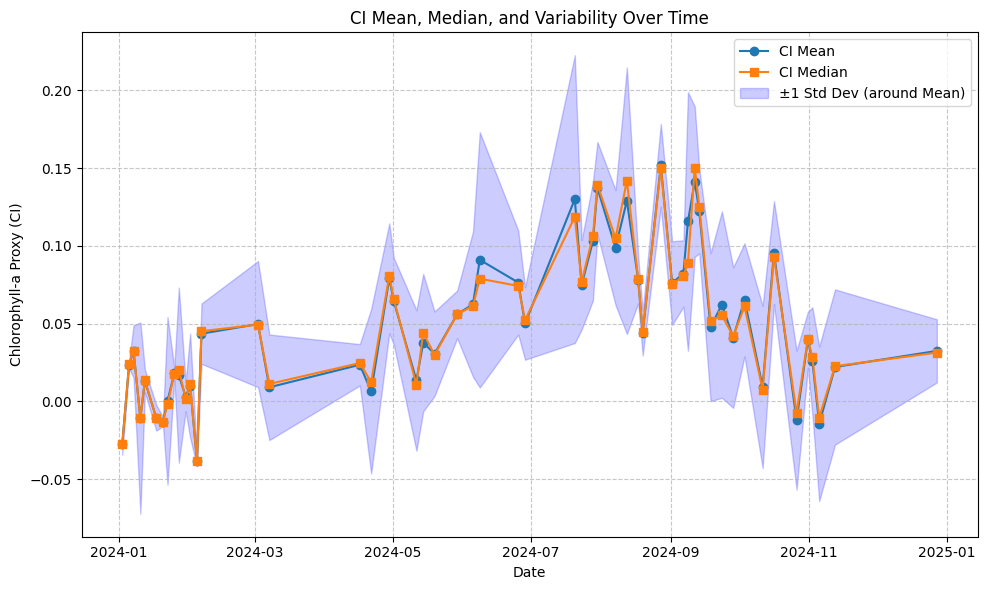

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot mean and median
plt.plot(df['date'], df['ci_mean'], label='CI Mean', marker='o')
plt.plot(df['date'], df['ci_median'], label='CI Median', marker='s')

# Add shaded area for ±1 std deviation around the mean
plt.fill_between(
    df['date'],
    df['ci_mean'] - df['ci_stdDev'],
    df['ci_mean'] + df['ci_stdDev'],
    color='blue',
    alpha=0.2,
    label='±1 Std Dev (around Mean)'
)

# Labels and title
plt.xlabel('Date')
plt.ylabel('Chlorophyll-a Proxy (CI)')
plt.title('CI Mean, Median, and Variability Over Time')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
